# Signaux III : projet detection de claviers

## **1. Prétraitement d’image**

**Objectif :** obtenir une image claire, binarisée et prête pour l’analyse des touches.

Étapes :

1. **Conversion en niveaux de gris** → `img_gray = rgb2gray(img)`
2. **Réduction de bruit** : filtre moyenneur ou médian.
3. **Amélioration du contraste** : histogramme égalisé.
4. **Seuillage automatique** (Otsu ou manuel) → `img_bin`.
5. **Morphologie** :

    - `ouverture` pour enlever les petits points.
    - `fermeture` pour combler les trous dans les touches.

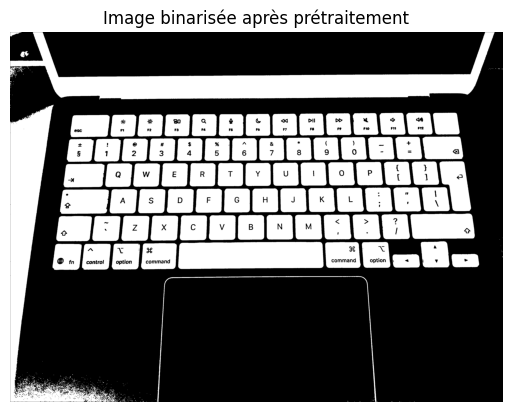

In [1]:
# Importer les dépendances
import os, sys
import matplotlib.pyplot as plt
from skimage import io

# Ajouter le répertoire parent au chemin Python pour que 'src' puisse être trouvé
sys.path.append(os.path.abspath('..'))

# Importer la fonction de prétraitement depuis preprocessing.py
from src.preprocessing import pretraiter_image

# Charger l’image d’entrée et appliquer le prétraitement pour obtenir une image binaire
chemin_image = '../data/img/INT-qwerty-1.jpg'
binaire = pretraiter_image(io.imread(chemin_image))

# Afficher l’image binaire résultante en niveaux de gris
plt.imshow(binaire, cmap='gray')
plt.title('Image binarisée après prétraitement')
plt.axis('off')
plt.show()

>À ce stade : on obtient une image “noir et blanc” où chaque touche est une forme blanche isolée.

---

## **2. Détection des touches individuelles**

**Objectif :** repérer les touches et extraire leur géométrie.

- **Contours** : appliquer un algorithme de recherche de composantes connexes ou de contours (implémenté à la main si besoin).
- **Filtrage des régions** :

    - Supprimer les très petites ou très grandes (bruit, bords du clavier).
    - Garder les rectangles approximatifs.
- **Approximation rectangulaire** : calculer le rectangle englobant chaque touche.
- **Visualisation** : afficher les bounding boxes pour vérification.

In [2]:
from src.key_detection import detecter_touches

# Charger et binariser l’image
chemin_image = '../data/img/INT-qwerty-1.jpg'
binaire = pretraiter_image(io.imread(chemin_image))

# Détecter les touches
touches = detecter_touches(binaire, aire_min=500, aire_max=8000, afficher=True)

print(f"{len(touches)} touches détectées")

ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1000x600 with 1 Axes>

8 touches détectées
